In [13]:
import numpy as np
import matplotlib.pyplot as plt


In [14]:
# Global parameters
total_years = 20 # this will be calculated based on study start and end dates

In [15]:
# Adoption model differential eq Parameters
dt = 1/10
time = np.arange(0, total_years, dt)
n = len(time)

In [16]:
#Competition group and building type specific Inputs
nc_per_year = 10 #this value will be an input table from the characterizer
nc = nc_per_year * dt 
nc_arr = np.full(n, nc)  # Create an array for plotting this is the new construction per time step
# initialize an array of cumulative annual totals for nc
nc_cumulative_annual = np.zeros(n)

In [17]:
# Initialize arrays
total_stock = np.zeros(n)
remaining_stock = np.zeros(n)
ret_er_stock = np.zeros(n)
rob_stock = np.zeros(n)
# Substocks within remaining_stock
remaining_below_baseline_stock = np.zeros(n)
remaining_baseline_stock = np.zeros(n)
remaining_efficient_stock = np.zeros(n)
# Substocks within ret_er_stock
ret_er_below_baseline_stock = np.zeros(n)
ret_er_baseline_stock = np.zeros(n)
ret_er_efficient_stock = np.zeros(n)
# Substocks within rob_stock
rob_below_baseline_stock = np.zeros(n)
rob_baseline_stock = np.zeros(n)
rob_efficient_stock = np.zeros(n)

  #initialize the array 
remaining_below_baseline_stock = np.zeros(n)
remaining_baseline_stock = np.zeros(n)
remaining_efficient_stock = np.zeros(n)
ret_er_below_baseline_stock = np.zeros(n)
ret_er_baseline_stock = np.zeros(n)
ret_er_efficient_stock = np.zeros(n)
rob_below_baseline_stock = np.zeros(n)
rob_baseline_stock = np.zeros(n)
rob_efficient_stock = np.zeros(n)
    


In [18]:
# Initial conditions
# what we have here is just temp values to get everything to run - these values will be calculated based on the global inputs/config file
total_stock[0] = 1000

non_rob_stock = total_stock[0] * 0.9 # this value needs to be 1-(1/EUL) of each individual condition 
# Is it going to be a problem if the conditions in the competition group have different EULs?
ret_er_stock[0] = non_rob_stock * (1/3) 
remaining_stock[0] = non_rob_stock * (2/3)
rob_stock[0] =  total_stock[0] - non_rob_stock #we need to see where this .01 of the population goes


# Initial conditions for remaining substocks
# this will be calculated by multiplying the utility customer counts of the specific building type by the Market Multiplier 
# (number of that condition and efficiency level in the building type) both of these will be input tables received from the characterizer)
remaining_below_baseline_stock[0] = remaining_stock[0] * 0.2
remaining_baseline_stock[0] = remaining_stock[0] * 0.6
remaining_efficient_stock[0] = remaining_stock[0] * 0.2

ret_er_below_baseline_stock[0] = ret_er_stock[0] * 0.2 # I dont think these values should ever be different than the remaining stock values because we are not doing a year by year thing just using this to track ret_er
ret_er_baseline_stock[0] = ret_er_stock[0] * 0.6
ret_er_efficient_stock[0] = ret_er_stock[0] * 0.2
# add on Measure we can do whenever (time invariant)
# early retirement replacement assumption implicit assumption that the equipment is already a certain age - 2/3 rule of thumb

# Initial conditions for rob substocks
rob_below_baseline_stock[0] = rob_stock[0] * 0.2
rob_baseline_stock[0] = rob_stock[0] * 0.6
rob_efficient_stock[0] = rob_stock[0] * 0.2

In [19]:
#these retirement rates will come from the condition input sheet for each condition (can they be unique to each condition?)
#is er and Add on a calculable value?
rob_retirement_rate = 1
ret_er_retirement_rate = 0.02
ret_add_on_retirement_rate = 0.02

In [20]:
def tech_eq(Below_Baseline, Baseline, Efficient, m, retirement_rate):
    Tech_Value = 1 # this is 100 percent as that is the definition of technical potential
    Retirement_Flow = m * retirement_rate #(m is the size of the stock)
    Efficient_Adoption_Flow = Retirement_Flow * Tech_Value
    Remaining_Flow = Retirement_Flow - Efficient_Adoption_Flow
    Baseline_Adoption_Flow = Remaining_Flow # should be zero as this is technical but left in for future
    Below_Baseline_Adoption_Flow = 0.0
    
    dEfficient_dt = Efficient_Adoption_Flow - (Efficient * retirement_rate)
    dBaseline_dt = Baseline_Adoption_Flow - (Baseline * retirement_rate)
    dBelow_Baseline_dt = Below_Baseline_Adoption_Flow - (Below_Baseline * retirement_rate)
    
    return dBelow_Baseline_dt, dBaseline_dt, dEfficient_dt

In [21]:
for t in range(1, n):
    # Add new construction to total stock
    total_stock[t] = total_stock[t-1] + nc #add here removal of demolition we will also need to figure out reno

    # --- Apply Tech to Early RETROFIT MARKET ---
    dBB_ret_er, dB_ret_er, dE_ret_er = tech_eq(
        ret_er_below_baseline_stock[t-1],
        ret_er_baseline_stock[t-1],
        ret_er_efficient_stock[t-1],
        ret_er_stock[t-1],
        ret_er_retirement_rate  #technically the ret add on retirement rate applies to this stock as well but we need to be able to track the conditions with the market they get replaced by to get measures so I made an additional function below
    )
    temp_ret_er_below_baseline = max(ret_er_below_baseline_stock[t-1] + dBB_ret_er * dt, 0.0)
    temp_ret_er_baseline = max(ret_er_baseline_stock[t-1] + dB_ret_er * dt, 0.0)
    temp_ret_er_efficient = max(ret_er_efficient_stock[t-1] + dE_ret_er * dt, 0.0)

    # --- Apply Tech to MARKET DRIVEN MARKET ---
    dBB_rob, dB_rob, dE_rob = tech_eq(
        rob_below_baseline_stock[t-1],
        rob_baseline_stock[t-1],
        rob_efficient_stock[t-1],
        rob_stock[t-1],
        rob_retirement_rate
    )
    temp_rob_below_baseline = max(rob_below_baseline_stock[t-1] + dBB_rob * dt, 0.0)
    temp_rob_baseline = max(rob_baseline_stock[t-1] + dB_rob * dt, 0.0)
    temp_rob_efficient = max(rob_efficient_stock[t-1] + dE_rob * dt, 0.0)
    
    # --- Apply Tech to REMAINING MARKET ---
    dBB_rem, dB_rem, dE_rem = tech_eq(
        remaining_below_baseline_stock[t-1],
        remaining_baseline_stock[t-1],
        remaining_efficient_stock[t-1],
        remaining_stock[t-1],
        ret_add_on_retirement_rate
    )
    temp_ret_add_on_below_baseline = max(remaining_below_baseline_stock[t-1] + dBB_rem * dt, 0.0)
    temp_ret_add_on_baseline = max(remaining_baseline_stock[t-1] + dB_rem * dt, 0.0)
    temp_ret_add_on_efficient = max(remaining_efficient_stock[t-1] + dE_rem * dt, 0.0)
  
    # --- Apply Tech to the older part of Retrofit add on group ---
    dBB_ret_add_on_2, dB_ret_add_on_2, dE_ret_add_on_2 = tech_eq(
        ret_er_below_baseline_stock[t-1],
        ret_er_baseline_stock[t-1],
        ret_er_efficient_stock[t-1],
        ret_er_stock[t-1],
        ret_add_on_retirement_rate  
    )
    #pulling out ret_er as that will already be accounted for we are left with just the additional _add_on_2 stock
    temp_ret_add_on_2_below_baseline = ret_er_below_baseline_stock[t-1] - max(ret_er_below_baseline_stock[t-1] + dBB_ret_add_on_2 * dt, 0.0)
    temp_ret_add_on_2_baseline = ret_er_baseline_stock[t-1] - max(ret_er_baseline_stock[t-1] + dB_ret_add_on_2 * dt, 0.0)
    temp_ret_add_on_2_efficient = ret_er_efficient_stock[t-1] - max(ret_er_efficient_stock[t-1] + dE_ret_add_on_2 * dt, 0.0)

    # --- Move stocks between markets ---
    new_rob_below_baseline_stock = temp_ret_er_below_baseline * (1/3) #assuming eul 10 then ret ER is 3 years so only 1 third of it will move to rob
    new_ret_er_below_baseline_stock = temp_ret_er_below_baseline * (2/3) + temp_ret_add_on_below_baseline * (1/6) #two thirds of the current ret_er stock remains in ret_er plus 1/6th of the current remaining stock
    new_remaining_below_baseline_stock = temp_ret_add_on_below_baseline * (5/6) + temp_rob_below_baseline + temp_ret_add_on_2_below_baseline #five sixths of the current remaining stock remains in remaining plus all of the rob turnover stock plus all of the ret add on 2 which is just the those that turned over from the ER stock

    new_rob_baseline_stock = temp_ret_er_baseline * (1/3) #assuming eul 10 then ret ER is 3 years so only 1 third of it will move to rob
    new_ret_er_baseline_stock = temp_ret_er_baseline * (2/3) + temp_ret_add_on_baseline * (1/6) #two thirds of the current ret_er stock remains in ret_er plus 1/6th of the current remaining stock
    new_remaining_baseline_stock = temp_ret_add_on_baseline * (5/6) + temp_rob_baseline + temp_ret_add_on_2_baseline #five sixths of the current remaining stock remains in remaining plus all of the rob turnover stock plus all of the ret add on 2 which is just the those that turned over from the ER stock

    new_rob_efficient_stock = temp_ret_er_efficient * (1/3) #assuming eul 10 then ret ER is 3 years so only 1 third of it will move to rob
    new_ret_er_efficient_stock = temp_ret_er_efficient * (2/3) + temp_ret_add_on_efficient * (1/6) #two thirds of the current ret_er stock remains in ret_er plus 1/6th of the current remaining stock
    new_remaining_efficient_stock = temp_ret_add_on_efficient * (5/6) + temp_rob_efficient + temp_ret_add_on_2_efficient #five sixths of the current remaining stock remains in remaining plus all of the rob turnover stock plus all of the ret add on 2 which is just the those that turned over from the ER stock
    

    # --- Add new construction to ret_stock substocks ---
    remaining_below_baseline_stock[t] = new_remaining_below_baseline_stock + (nc * 0) #proportioning nc here but should make this an input
    remaining_baseline_stock[t] = new_remaining_baseline_stock + (nc * 0.5)
    remaining_efficient_stock[t] = new_remaining_efficient_stock + (nc * 0.5)

    ret_er_below_baseline_stock[t] = new_ret_er_below_baseline_stock  #here we will add in demo like nc
    ret_er_baseline_stock[t] = new_ret_er_baseline_stock 
    ret_er_efficient_stock[t] = new_ret_er_efficient_stock 

    rob_below_baseline_stock[t] = new_rob_below_baseline_stock
    rob_baseline_stock[t] = new_rob_baseline_stock
    rob_efficient_stock[t] = new_rob_efficient_stock

    # --- Update market totals ---
    ret_er_stock[t] = ret_er_below_baseline_stock[t] + ret_er_baseline_stock[t] + ret_er_efficient_stock[t]
    rob_stock[t] = rob_below_baseline_stock[t] + rob_baseline_stock[t] + remaining_efficient_stock[t]
    remaining_stock[t] = remaining_below_baseline_stock[t] + remaining_baseline_stock[t] + rob_efficient_stock[t]
    total_stock[t] = rob_stock[t] + ret_er_stock[t] + remaining_stock[t]

NameError: name 'ret_stock' is not defined

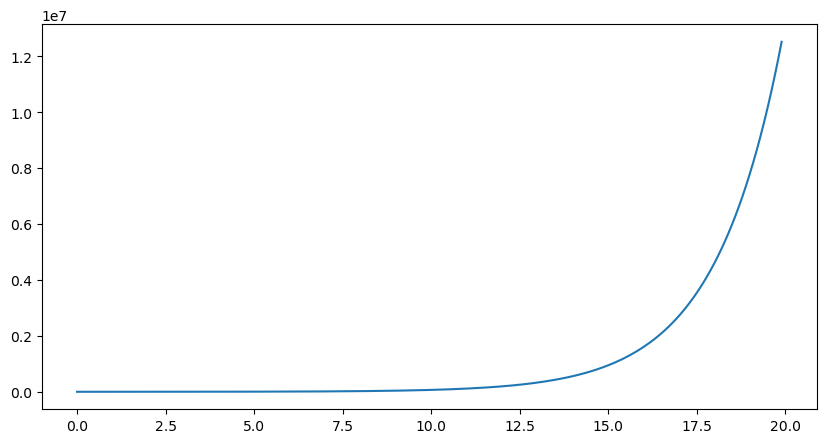

In [22]:
# Plotting
plt.figure(figsize=(10, 5))
plt.plot(time, total_stock, label="Total Stock")
plt.plot(time, ret_stock, label="Retrofit Stock (ret)")
# plt.plot(time, md_stock, label="Market Driven Stock (md)")
# plt.plot(time, nc_arr, label="New Construction Distrupter (nc)")
# plt.plot(time, nc_cumulative_total, label="Cumulative Annual New Construction (nc)")
plt.plot(time, ret_below_baseline_stock, label="Ret_Below Baseline Stock")
plt.plot(time, ret_baseline_stock, label="Ret_Baseline Stock")
plt.plot(time, ret_efficient_stock, label="Ret_Efficient Stock")
for i in range(0, len(time), 10):
    plt.text(time[i], total_stock[i], f"{total_stock[i]:.1f}", fontsize=8, ha='center', va='bottom', color='tab:blue')
    # plt.text(time[i], md_stock[i], f"{md_stock[i]:.1f}", fontsize=8, ha='center', va='bottom', color='tab:green')
    plt.text(time[i], ret_stock[i], f"{ret_stock[i]:.1f}", fontsize=8, ha='center', va='bottom', color='tab:orange')
    plt.text(time[i], ret_below_baseline_stock[i], f"{ret_below_baseline_stock[i]:.1f}", fontsize=8, ha='center', va='bottom', color='tab:orange')
    plt.text(time[i], ret_baseline_stock[i], f"{ret_baseline_stock[i]:.1f}", fontsize=8, ha='center', va='bottom', color='tab:orange')
    plt.text(time[i], ret_efficient_stock[i], f"{ret_efficient_stock[i]:.1f}", fontsize=8, ha='center', va='bottom', color='tab:orange')
    # plt.text(time[i], nc_arr[i], f"{nc_arr[i]:.1f}", fontsize=8, ha='center', va='bottom', color='tab:red')
    # plt.text(time[i], nc_cumulative_total[i], f"{nc_cumulative_total[i]:.1f}", fontsize=8, ha='center', va='bottom', color='tab:purple')
plt.xlabel("Time (years)")
plt.ylabel("Number of Units")
plt.title("RET Equipment Stock Over Time")
plt.legend()
plt.tight_layout()
plt.show()

# Plotting
plt.figure(figsize=(10, 5))
#plt.plot(time, total_stock, label="Total Stock")
plt.plot(time, md_stock, label="Market Driven Stock (md)")
# plt.plot(time, nc_arr, label="New Construction Distrupter (nc)")
# plt.plot(time, nc_cumulative_total, label="Cumulative Annual New Construction (nc)")
plt.plot(time, md_below_baseline_stock, label="MD_Below Baseline Stock")
plt.plot(time, md_baseline_stock, label="MD_Baseline Stock")
plt.plot(time, md_efficient_stock, label="MD_Efficient Stock")
for i in range(0, len(time), 10):
   # plt.text(time[i], total_stock[i], f"{total_stock[i]:.1f}", fontsize=8, ha='center', va='bottom', color='tab:blue')
    # plt.text(time[i], md_stock[i], f"{md_stock[i]:.1f}", fontsize=8, ha='center', va='bottom', color='tab:green')
    plt.text(time[i], md_stock[i], f"{md_stock[i]:.1f}", fontsize=8, ha='center', va='bottom', color='tab:orange')
    plt.text(time[i], md_below_baseline_stock[i], f"{md_below_baseline_stock[i]:.1f}", fontsize=8, ha='center', va='bottom', color='tab:orange')
    plt.text(time[i], md_baseline_stock[i], f"{md_baseline_stock[i]:.1f}", fontsize=8, ha='center', va='bottom', color='tab:orange')
    plt.text(time[i], md_efficient_stock[i], f"{md_efficient_stock[i]:.1f}", fontsize=8, ha='center', va='bottom', color='tab:orange')
    # plt.text(time[i], nc_arr[i], f"{nc_arr[i]:.1f}", fontsize=8, ha='center', va='bottom', color='tab:red')
    # plt.text(time[i], nc_cumulative_total[i], f"{nc_cumulative_total[i]:.1f}", fontsize=8, ha='center', va='bottom', color='tab:purple')
plt.xlabel("Time (years)")
plt.ylabel("Number of Units")
plt.title("MD Equipment Stock Over Time")
plt.legend()
plt.tight_layout()
plt.show()